In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from analyses.helpers.load import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [8]:
lang_codes = ["ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = load_aggregated("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
hofstede

,pdi,idv,mas,uai,ltowvs,ivr
ctr,,,,,,
DEN,18,74,16,23,35,70
FIN,33,63,26,59,38,57
FRA,68,71,43,86,63,48
GER,35,67,66,65,83,40
ITA,50,76,70,75,61,30
JPN,54,46,95,92,88,42
KOR,60,18,39,85,100,29
NET,38,80,14,53,67,68
NOR,31,69,8,50,35,55


In [9]:
dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

all_data = []

for language in codes:
    language_data = agg[language]
    for topic, topic_data in language_data["topics"].items():
        for d, views in topic_data["sum"].items():
            all_data.append({"lang": language, "topic": topic, "date": d, "views": views})
df = pd.DataFrame.from_dict(all_data)

In [10]:
df_desktop = df[df.lang.apply(lambda l : l in lang_codes)]
df_mobile = df[df.lang.apply(lambda l : l[-2:] == ".m")]
df_mobile.loc[:,"lang"] = df_mobile.lang.apply(lambda l: l[:-2])

In [11]:
df = pd.concat([df_desktop, df_mobile]).groupby(["lang", "topic", "date"]).sum().reset_index()

In [12]:
df["log_views"] = np.log(df.views)

In [13]:
df.head()

,lang,topic,date,views,log_views
0,ca,Culture.Biography.Biography*,2018-01-01,68986,11.141659
1,ca,Culture.Biography.Biography*,2018-01-02,65138,11.084263
2,ca,Culture.Biography.Biography*,2018-01-03,62817,11.047981
3,ca,Culture.Biography.Biography*,2018-01-04,67250,11.116172
4,ca,Culture.Biography.Biography*,2018-01-05,57697,10.962960


In [14]:
df["weekofyear"] = df.date.dt.isocalendar().week
df["year"] = df.date.dt.isocalendar().year

## Total number of views per language

In [15]:
df.groupby("lang").views.sum().sort_values(ascending=False)

lang
ja    66697912133
de    58371904626
fr    47634003329
it    37981254279
nl     9260562325
sv     5264677265
ko     4309682617
fi     3771969379
tr     2567376186
no     2172941980
da     1811082678
sr     1729553733
ca     1103548916
Name: views, dtype: int64

## Total number of views per topic

In [16]:
df.groupby("topic").views.sum().sort_values(ascending=False).head()

topic
Culture.Biography.Biography*        25594719421
Culture.Media.Media*                21294300850
Geography.Regions.Europe.Europe*    20925804957
STEM.STEM*                          17896840671
Geography.Regions.Asia.Asia*        12689883059
Name: views, dtype: int64

## Total number of views per topic (discarding metatopics and geography topics)

In [17]:
df[df.topic.apply(lambda t: (t[-1] != "*") & (not t.startswith("Geography")))].groupby("topic").views.sum().sort_values(ascending=False).head()

topic
Culture.Sports             7077353098
Culture.Literature         6853606499
Culture.Biography.Women    5888444228
Culture.Media.Films        5051345049
Culture.Media.Music        4981860737
Name: views, dtype: int64

In [18]:
df_simple = df[df.topic.apply(lambda t: (t[-1] != "*") & (not t.startswith("Geography")))]

## General views over the year

<Axes: xlabel='date', ylabel='log_views'>

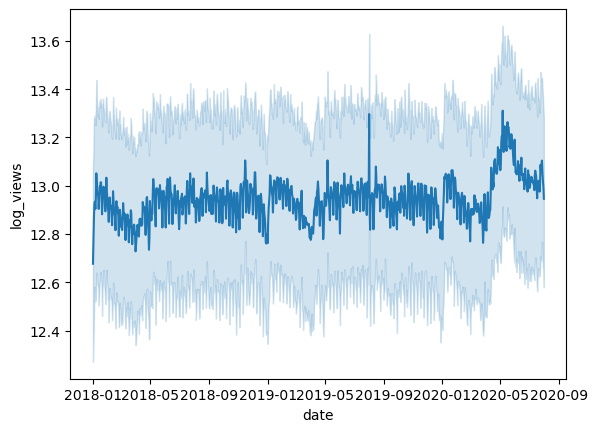

In [19]:
sns.lineplot(df_simple[df_simple.lang == "ja"], x="date", y="log_views")

<Axes: xlabel='date', ylabel='log_views'>

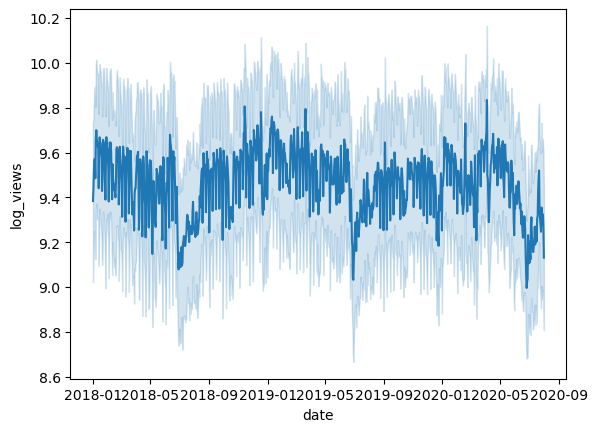

In [20]:
sns.lineplot(df_simple[df_simple.lang == "da"], x="date", y="log_views")

## Detect outliers

Outlier detection takes about 1 minute to run...

In [21]:
from sklearn.ensemble import IsolationForest

def outlier_detection(x):
    clf = IsolationForest(contamination=0.05, random_state=42) 
    return clf.fit_predict(x.to_numpy().reshape((-1, 1)))

df_simple.loc[:, "valid"] = df_simple.groupby(["lang", "topic"]).views.transform(outlier_detection)

C:\Users\jybur\AppData\Local\Temp\ipykernel_13988\3577672098.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple.loc[:, "valid"] = df_simple.groupby(["lang", "topic"]).views.transform(outlier_detection)


<Axes: xlabel='date', ylabel='log_views'>

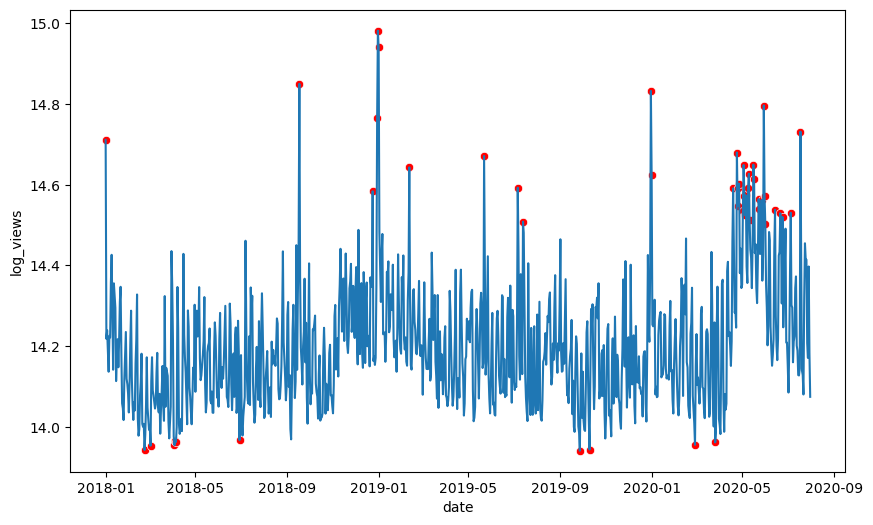

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(df_simple[(df_simple.lang == "ja") & (df_simple.topic == "Culture.Media.Music")], x="date", y="log_views", ax=ax)
sns.scatterplot(df_simple[(df_simple.lang == "ja") & (df_simple.topic == "Culture.Media.Music") & (df_simple.valid == -1)], x="date", y="log_views", ax=ax, color="red")

## Topics views over the year

C:\Users\jybur\AppData\Local\Temp\ipykernel_13988\1723909216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple.loc[:,"month"] = df_simple.date.to_numpy().astype('datetime64[M]')
C:\Users\jybur\AppData\Local\Temp\ipykernel_13988\1723909216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple.loc[:,'week'] = df_simple.date - df_simple.date.dt.weekday * np.timedelta64(1, 'D')


<Axes: xlabel='month', ylabel='log_views'>

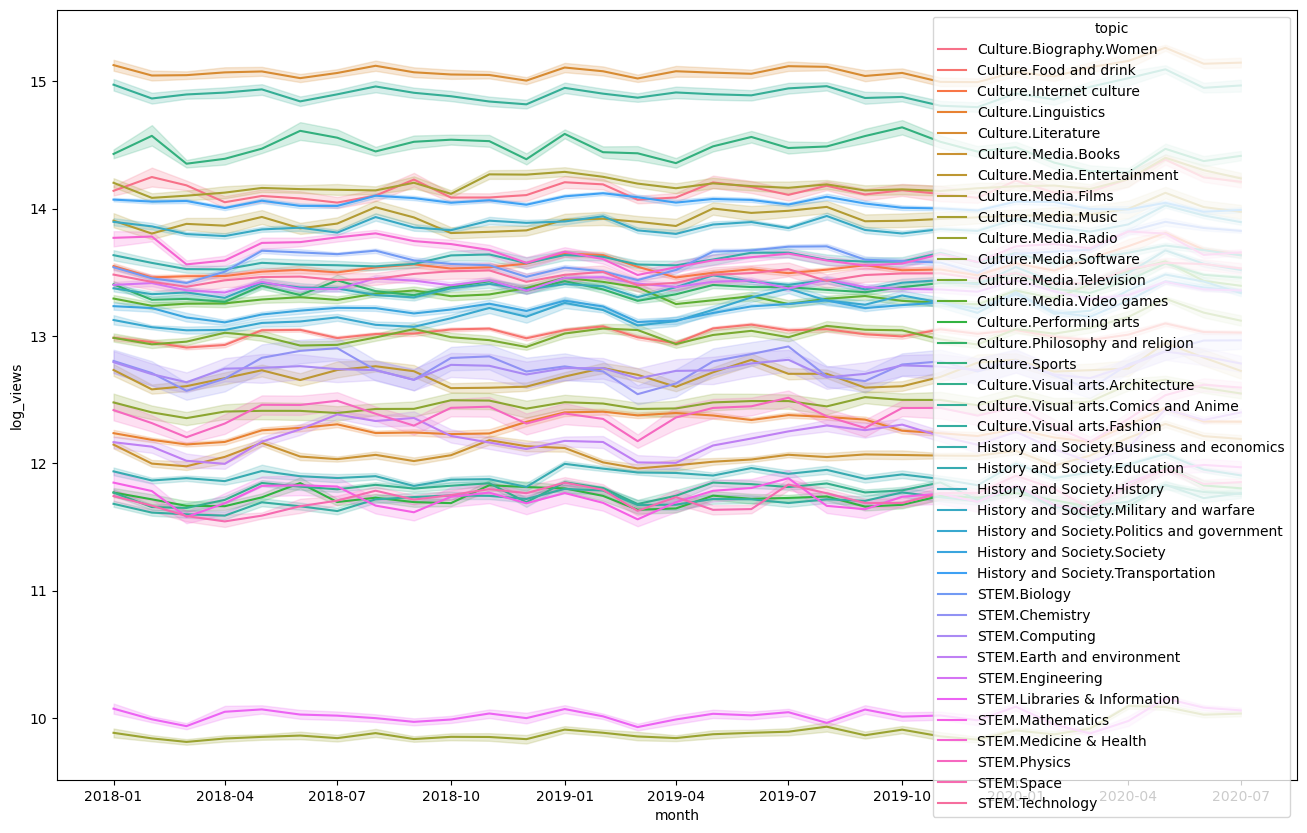

In [23]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
df_simple.loc[:,"month"] = df_simple.date.to_numpy().astype('datetime64[M]')
df_simple.loc[:,'week'] = df_simple.date - df_simple.date.dt.weekday * np.timedelta64(1, 'D')
sns.lineplot(df_simple[(df_simple.lang == "ja") & (df_simple.valid == 1)], x="month", y="log_views", hue="topic", legend="brief", ax=ax)

In [40]:
pd.options.mode.chained_assignment = None
df_simple[df_simple.valid == 1].loc[:,"normalized_log_views"] = df_simple[df_simple.valid == 1].groupby(["lang", "topic"]).log_views.transform(lambda x : (x - x.mean())/x.std())

In [41]:
df_simple[df_simple.valid == 1].head()

,lang,topic,date,views,log_views,weekofyear,year,valid,month,week
943,ca,Culture.Biography.Women,2018-01-01,18565,9.829033,1,2018,1,2018-01-01,2018-01-01
944,ca,Culture.Biography.Women,2018-01-02,15890,9.673445,1,2018,1,2018-01-01,2018-01-01
945,ca,Culture.Biography.Women,2018-01-03,15031,9.617870,1,2018,1,2018-01-01,2018-01-01
946,ca,Culture.Biography.Women,2018-01-04,14589,9.588023,1,2018,1,2018-01-01,2018-01-01
948,ca,Culture.Biography.Women,2018-01-06,15404,9.642382,1,2018,1,2018-01-01,2018-01-01


ValueError: Could not interpret value `normalized_log_views` for parameter `y`

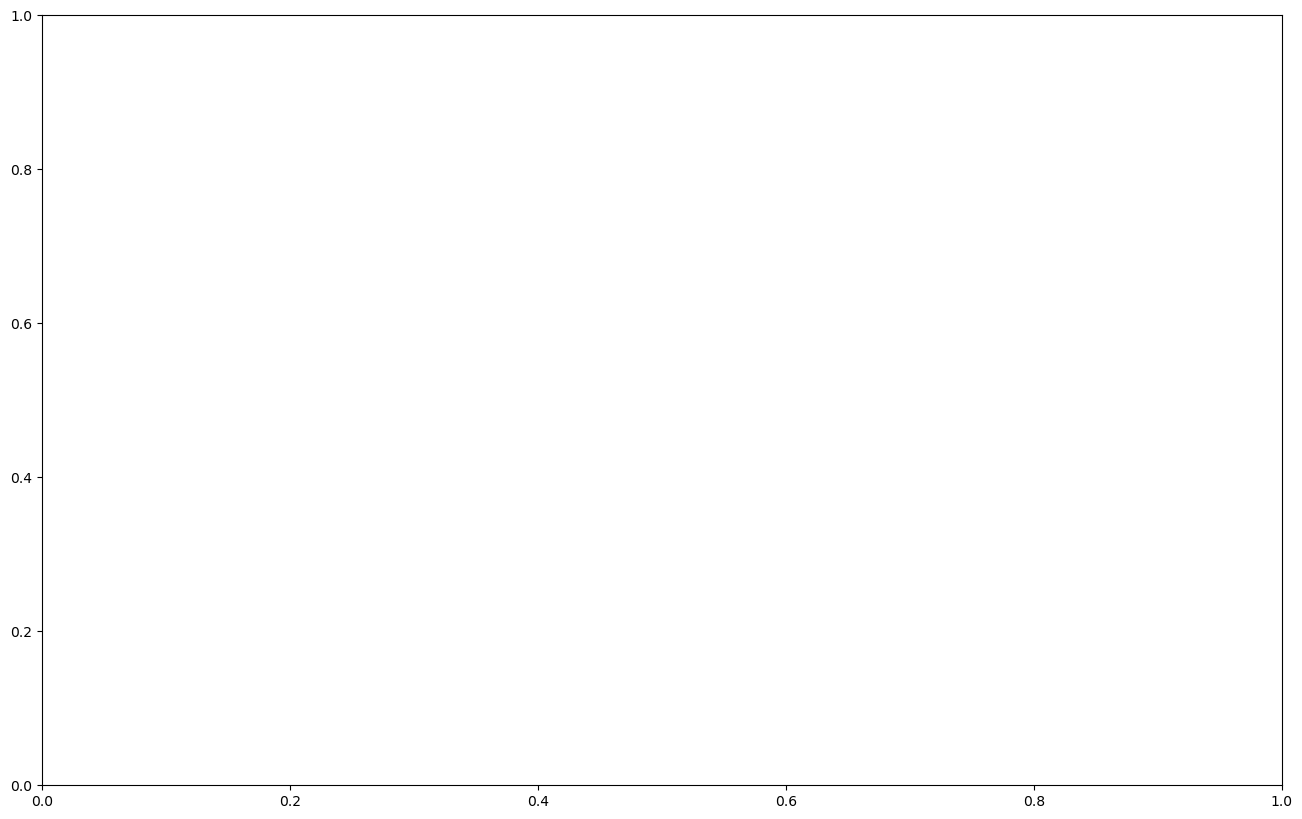

In [28]:
selected_topics = ["Culture.Food and drink", "Culture.Sports", "STEM.Mathematics"]

fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.lineplot(df_simple[(df_simple.lang == "ja") & (df_simple.valid == 1) & (df_simple.topic.apply(lambda l : l in selected_topics))], x="week", y="normalized_log_views", hue="topic", legend="brief", ax=ax)
ax.set_title("Trends in Japan")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.lineplot(df_simple[(df_simple.lang == "it") & (df_simple.valid == 1) & (df_simple.topic.apply(lambda l : l in selected_topics))], x="week", y="normalized_log_views", hue="topic", legend="brief", ax=ax)
ax.set_title("Trends in Italy")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.lineplot(df_simple[(df_simple.lang == "ko") & (df_simple.valid == 1) & (df_simple.topic.apply(lambda l : l in selected_topics))], x="week", y="normalized_log_views", hue="topic", legend="brief", ax=ax)
ax.set_title("Trends in Korea")

This takes a long time, a file with the precomputed values can be loaded instead below.

In [370]:
langs = df_simple.lang.unique()
corr_dfs = {}

for topic in df_simple.topic.unique():
    print(topic)
    data = []
    for lang1 in langs:
        for lang2 in langs:
            serie1 = df_simple[(df_simple.lang == lang1) & (df_simple.topic == topic) & (df_simple.valid == 1)].groupby("month").normalized_log_views.mean()
            serie1 = serie1.rename(lang1)

            serie2 = df_simple[(df_simple.lang == lang2) & (df_simple.topic == topic) & (df_simple.valid == 1)].groupby("month").normalized_log_views.mean()
            serie2 = serie2.rename(lang2)

            merged = pd.merge(serie1, serie2, left_on="month", right_on="month", how="inner")
            data.append({"lang1": lang1, "lang2": lang2, "corr": np.array(merged.corr())[0,1]})
    corr_df = pd.DataFrame.from_dict(data)
    corr_df = pd.pivot_table(corr_df, values="corr", index="lang1", columns="lang2")
    corr_dfs[topic] = corr_df

Culture.Biography.Women
Culture.Food and drink
Culture.Internet culture
Culture.Linguistics
Culture.Literature
Culture.Media.Books
Culture.Media.Entertainment
Culture.Media.Films
Culture.Media.Music
Culture.Media.Radio
Culture.Media.Software
Culture.Media.Television
Culture.Media.Video games
Culture.Performing arts
Culture.Philosophy and religion
Culture.Sports
Culture.Visual arts.Architecture
Culture.Visual arts.Comics and Anime
Culture.Visual arts.Fashion
History and Society.Business and economics
History and Society.Education
History and Society.History
History and Society.Military and warfare
History and Society.Politics and government
History and Society.Society
History and Society.Transportation
STEM.Biology
STEM.Chemistry
STEM.Computing
STEM.Earth and environment
STEM.Engineering
STEM.Libraries & Information
STEM.Mathematics
STEM.Medicine & Health
STEM.Physics
STEM.Space
STEM.Technology


In [ ]:
with open("results/corr_timeseries.pkl", "rb") as f:
    corr_dfs = pickle.load(f)

Text(0.5, 1.0, 'Time series correlation for Culture.Food and drink')

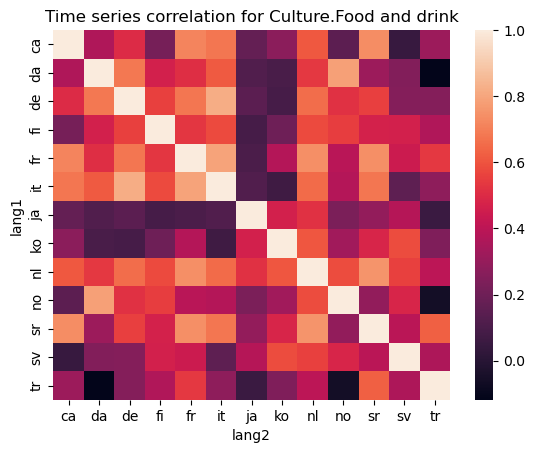

In [469]:
fig, ax = plt.subplots(1,1)
sns.heatmap(corr_dfs[selected_topics[0]], ax=ax)
ax.set_title(f"Time series correlation for {selected_topics[0]}")

Text(0.5, 1.0, 'Time series correlation for Culture.Sports')

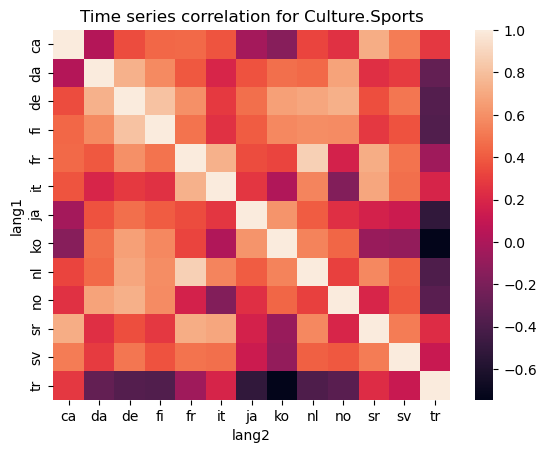

In [464]:
fig, ax = plt.subplots(1,1)
sns.heatmap(corr_dfs[selected_topics[1]], ax=ax)
ax.set_title(f"Time series correlation for {selected_topics[1]}")

Text(0.5, 1.0, 'Time series correlation for STEM.Mathematics')

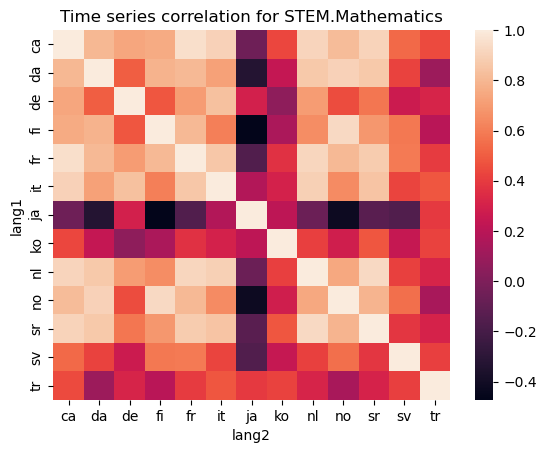

In [465]:
fig, ax = plt.subplots(1,1)
sns.heatmap(corr_dfs[selected_topics[2]], ax=ax)
ax.set_title(f"Time series correlation for {selected_topics[2]}")

In [466]:
lang_maps = {"JPN" : "ja", "KOR": "ko", "TUR": "tr", "SWE": "sv", "NOR": "no", "FIN": "fi", "DEN": "da", "SER": "sr", "ITA": "it", "SPA": "ca", "NET": "nl", "FRA": "fr", "GER": "de"}
lang_maps_inv = {}
for c,l in lang_maps.items():
    lang_maps_inv[l] = c

In [467]:
hof_data = []

for lang1 in lang_codes:
    for lang2 in lang_codes:
        e1 = hofstede.loc[lang_maps_inv[lang1],:].to_numpy()
        e2 = hofstede.loc[lang_maps_inv[lang2],:].to_numpy()

        hof_data.append({"lang1": lang1, "lang2": lang2, "hof_dist": -np.linalg.norm(e1-e2)})

hof_pd = pd.DataFrame.from_dict(hof_data)
hof_pd = hof_pd.pivot_table(values="hof_dist", index="lang1", columns="lang2")
hof_pd = (hof_pd - hof_pd.min())/(hof_pd.max() - hof_pd.min())

Text(0.5, 1.0, 'Hofstede score')

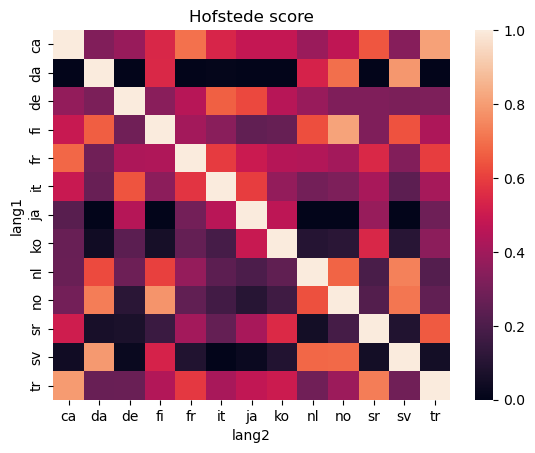

In [468]:
fig, ax = plt.subplots(1,1)
sns.heatmap(hof_pd, ax=ax)
ax.set_title(f"Hofstede score")

In [441]:
data = []
for topic in corr_dfs.keys():
    result = corr_dfs[topic].corrwith(hof_pd).mean()
    data.append({"topic": topic, "score": result})

pd.DataFrame.from_dict(data).set_index("topic").score.sort_values(ascending=False).head()

topic
Culture.Performing arts             0.657225
Culture.Visual arts.Architecture    0.641348
Culture.Media.Television            0.639077
Culture.Food and drink              0.606696
Culture.Media.Radio                 0.597797
Name: score, dtype: float64

From these results, we can see that the page view time series with topic of "Culture.Performing arts" reflects Hofstede the best for each country. 0.65 being quite a strong correlation coefficient.

Text(0.5, 1.0, 'Correlation between Cultural Dimensions and Page Views Trends in countries')

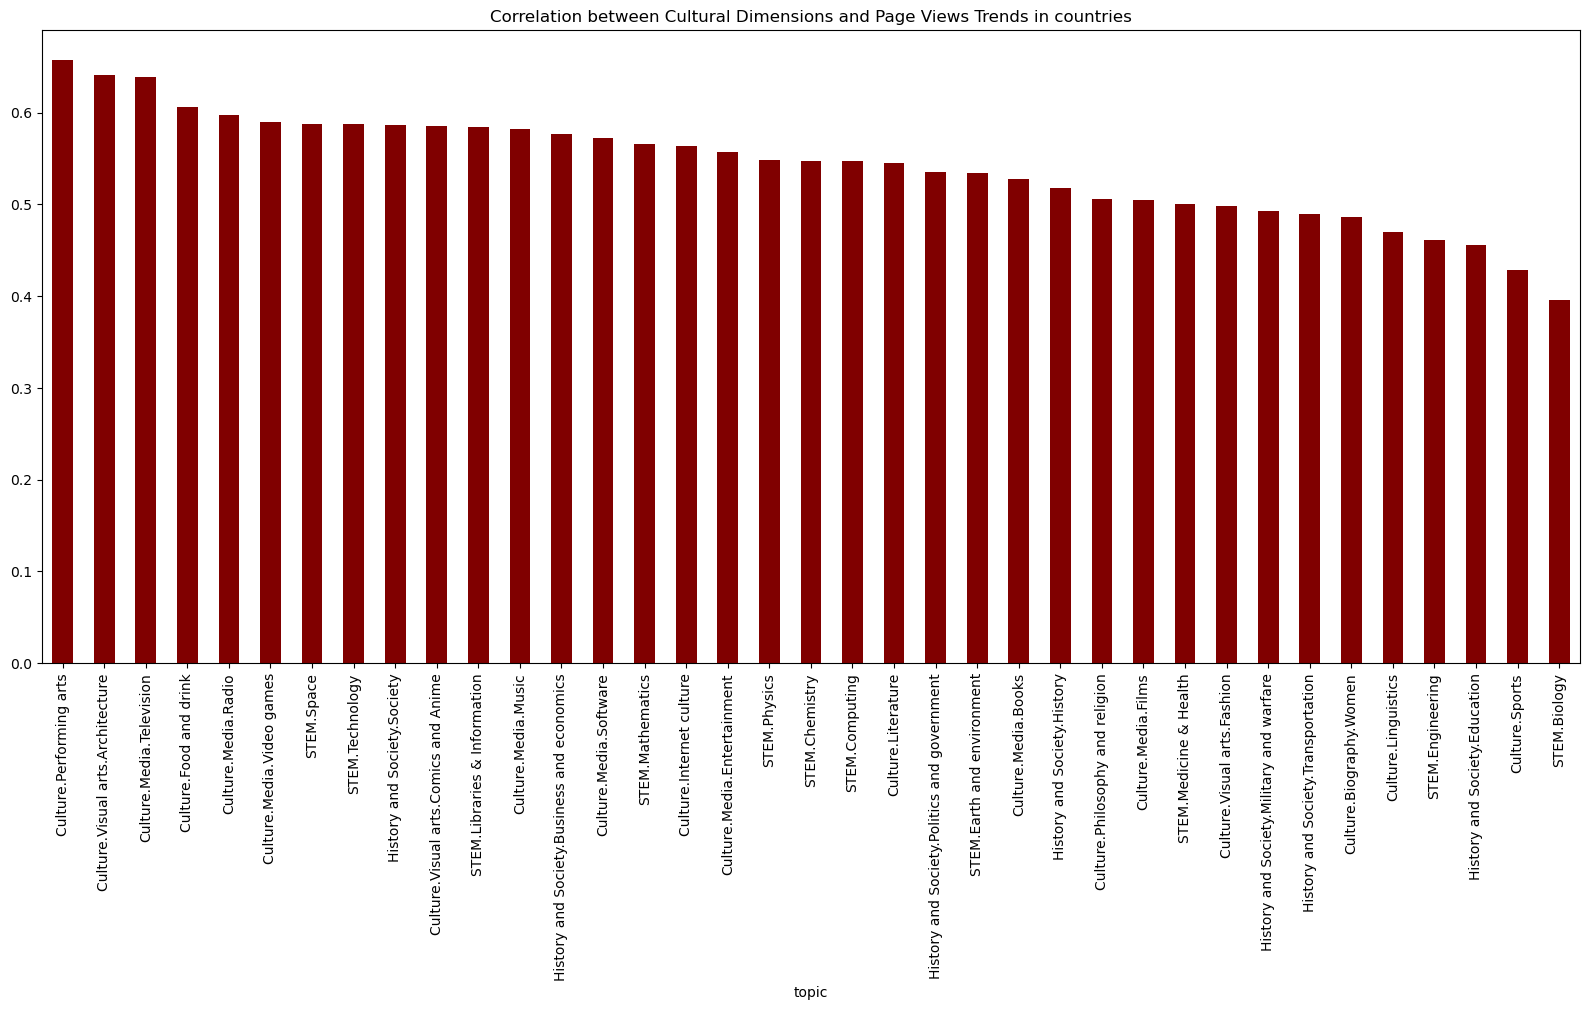

In [456]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
pd.DataFrame.from_dict(data).set_index("topic").score.sort_values(ascending=False).plot.bar(x = "topic", y = "score", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between all Cultural Dimensions and Page Views Trends in countries")

## Correlating Hofstede individual dimensions with topics

In [457]:
hof_data = []
hof_all = {}

for i in range(6):
    for lang1 in lang_codes:
        for lang2 in lang_codes:
            e1 = hofstede.loc[lang_maps_inv[lang1],:].to_numpy()
            e2 = hofstede.loc[lang_maps_inv[lang2],:].to_numpy()

            hof_data.append({"lang1": lang1, "lang2": lang2, "hof_dist": -np.linalg.norm(e1[i]-e2[i])})

    hof = pd.DataFrame.from_dict(hof_data)
    hof = hof.pivot_table(values="hof_dist", index="lang1", columns="lang2")
    hof = (hof - hof.min())/(hof.max() - hof.min())
    hof_all[hofstede.columns[i]] = hof

In [458]:
data = []
for i in range(6):
    for topic in corr_dfs.keys():
        result = corr_dfs[topic].corrwith(hof_all[hofstede.columns[i]]).mean()
        data.append({"topic": topic, "score": result, "dim": hofstede.columns[i]})
        
corr_all = pd.DataFrame.from_dict(data)

Now we can see with this metric which topic reflects each cultural dimension the best.

In [435]:
corr_all.dim.unique()

array(['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr'], dtype=object)

Text(0.5, 1.0, 'Correlation between Individuality and Page Views Trends in countries')

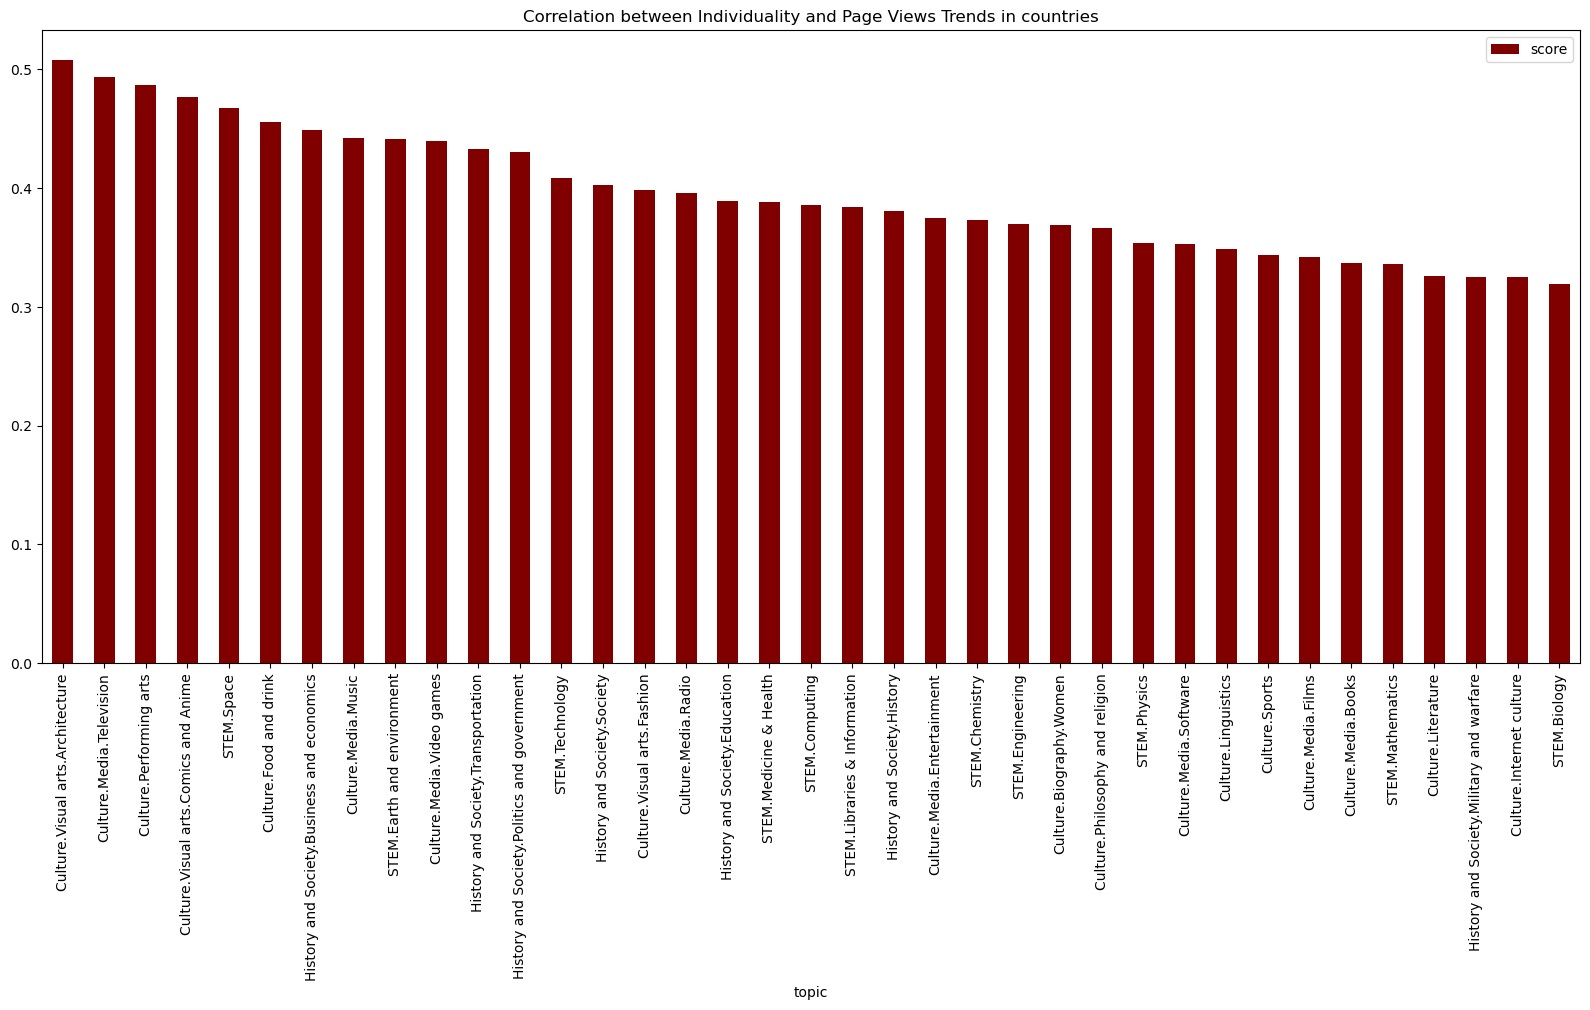

In [460]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_all[corr_all.dim == "idv"].sort_values("score", ascending=False).plot.bar(x = "topic", y = "score", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Individuality and Page Views Trends in countries")

The topics that reflect individuality using this metric.

Text(0.5, 1.0, 'Correlation between Long Term/Short Term orientation and Page Views Trends in countries')

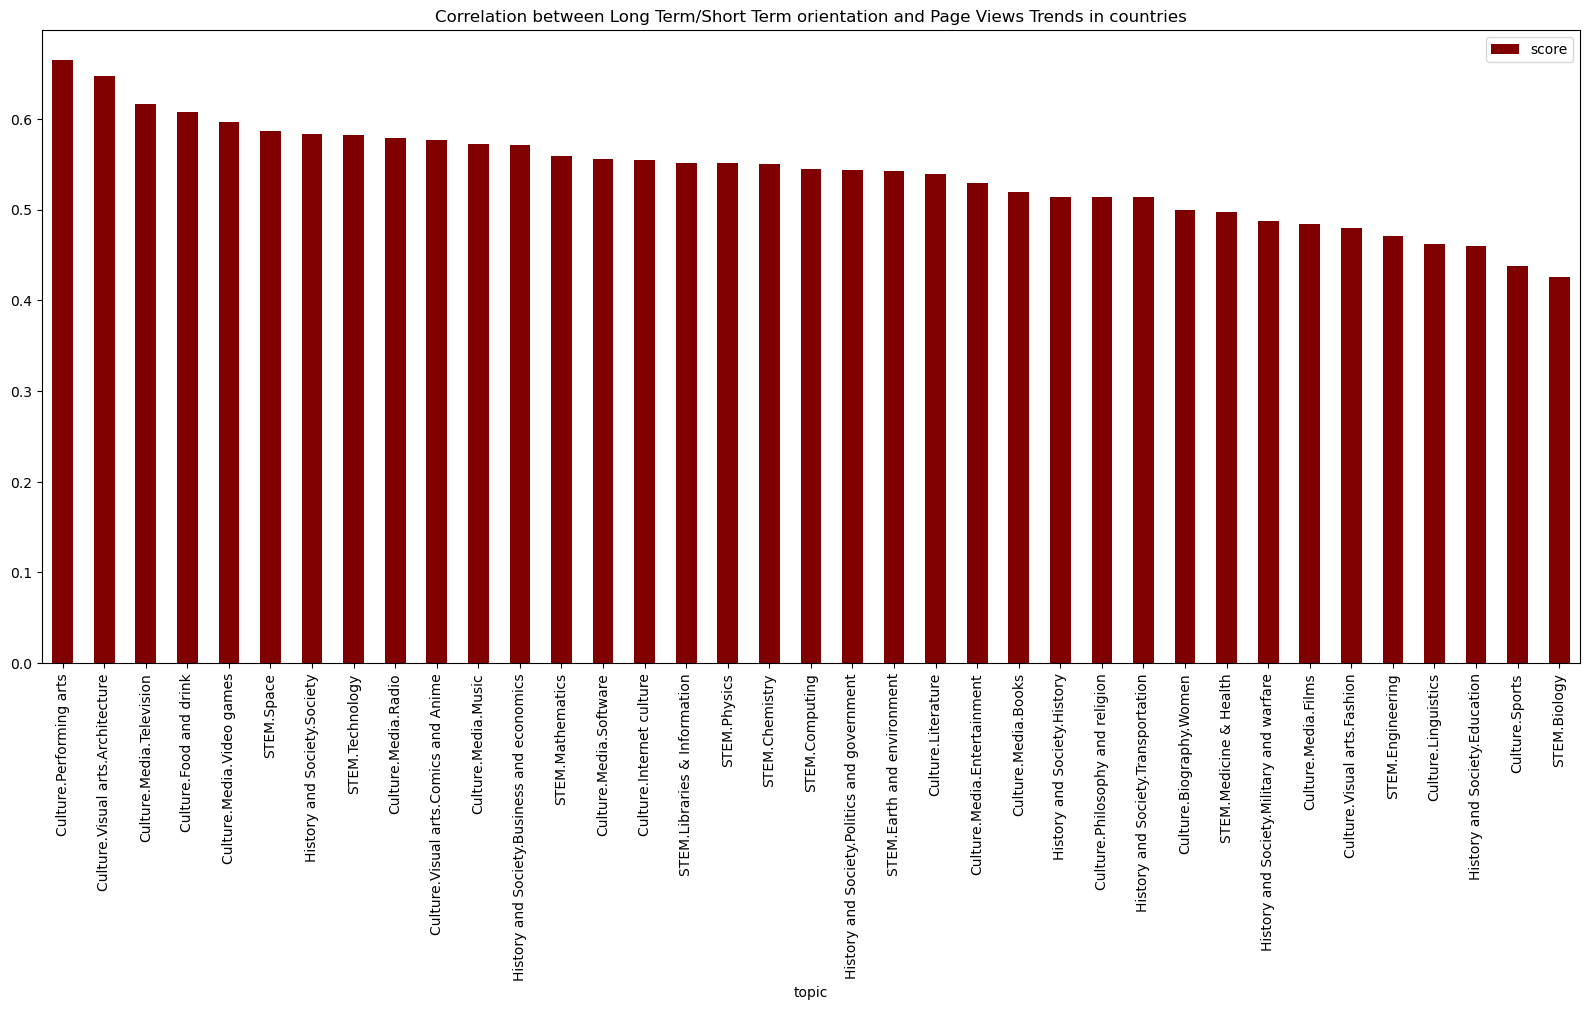

In [461]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_all[corr_all.dim == "ltowvs"].sort_values("score", ascending=False).plot.bar(x = "topic", y = "score", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Long Term/Short Term orientation and Page Views Trends in countries")

Topics that reflect Long Term/Short Term orientation

Text(0.5, 1.0, 'Correlation between Uncertainty Avoidance and Page Views Trends in countries')

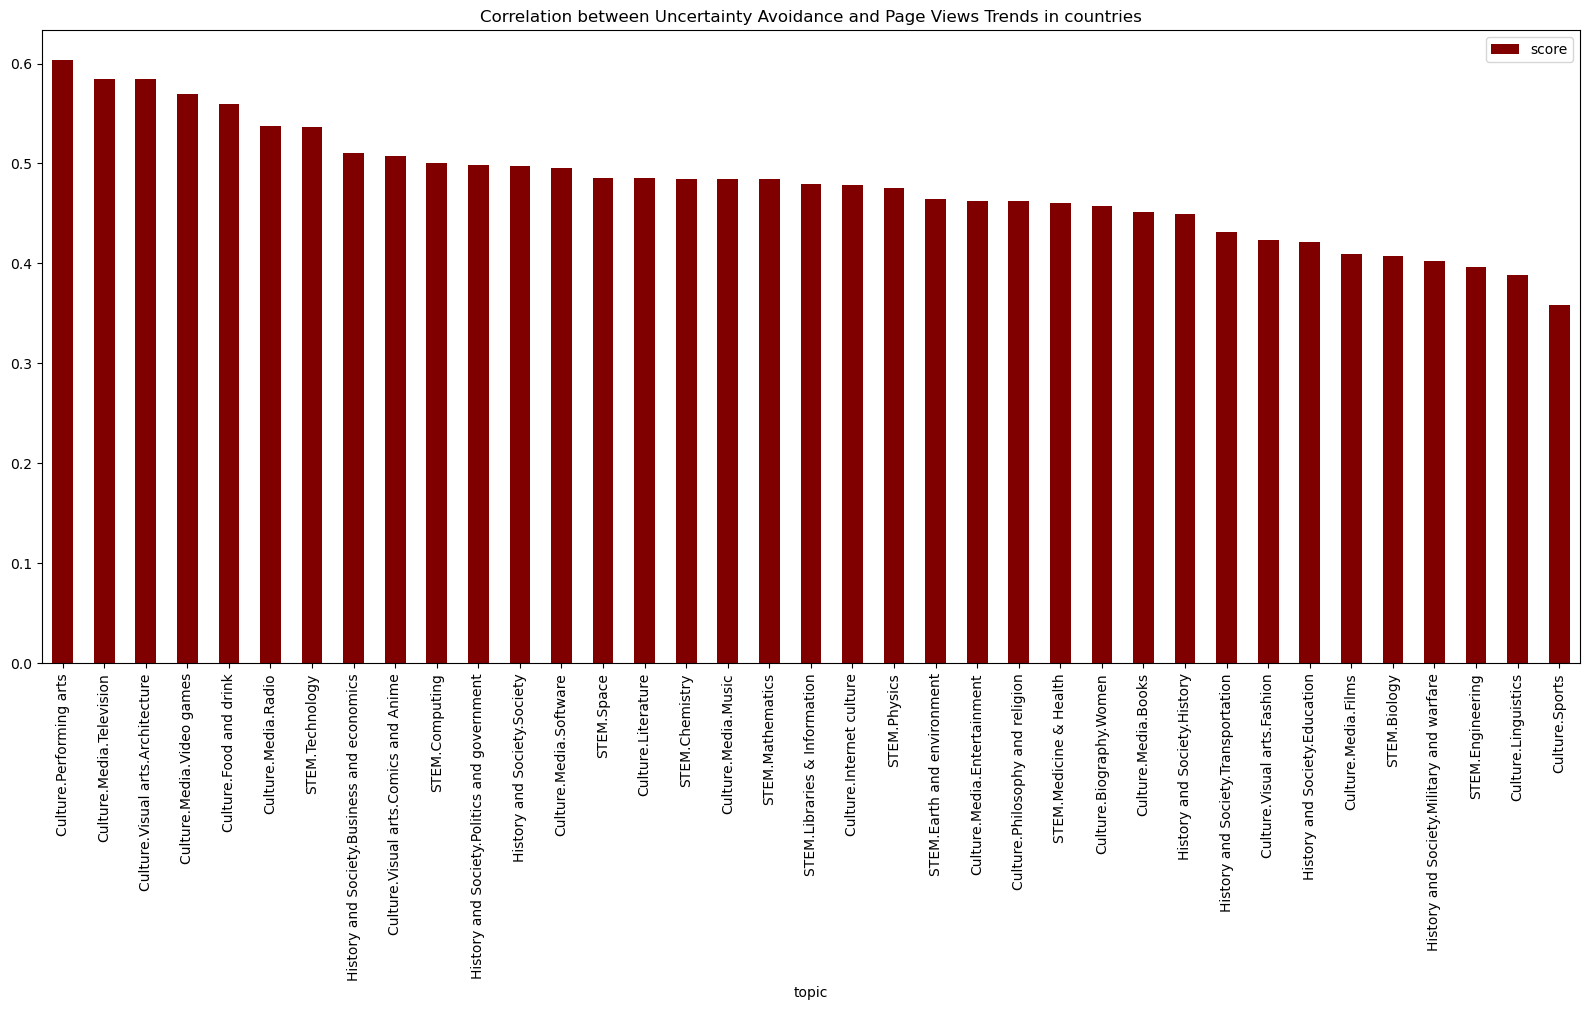

In [462]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_all[corr_all.dim == "uai"].sort_values("score", ascending=False).plot.bar(x = "topic", y = "score", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Uncertainty Avoidance and Page Views Trends in countries")

## ANOVA Analysis